In [1]:
from utility import *
import warnings
from concrete import fhe
from pprint import pprint

warnings.filterwarnings("ignore")

## Preprocessing

Since the circuit performance is the bottleneck of the whole system, we need to preprocess the data and the circuit as efficiently as possible. The following cells are used to preprocess the data and the query, which both has the same preprocessing.

### Step 1: Read the audio, extract the spectrogram

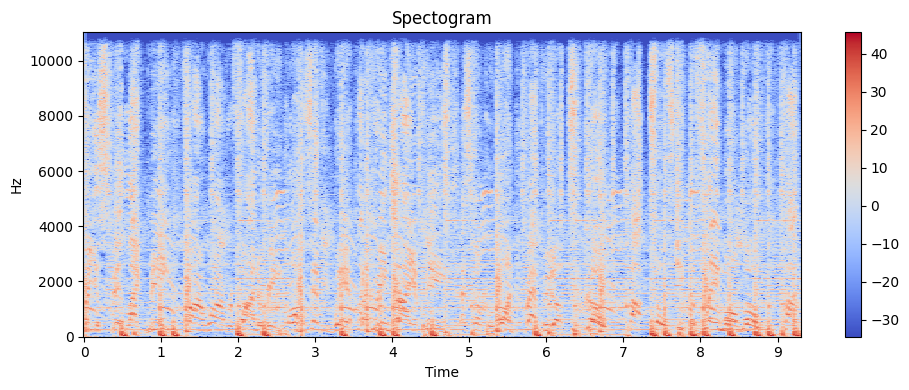

In [2]:
fft_results, sr = get_spectogram("data/fma_small/000/000002.mp3", record_length=10)

plt.figure(figsize=(10, 4))
librosa.display.specshow(fft_results, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar()
plt.title("Spectogram")
plt.tight_layout()
plt.show()

### Step 2: Extract the constellation map from the spectrogram

This step is not a common operation. Official Shazam's paper and the blog writing "How Shazam Works?" both claim that constellation map creation is crucial for the whole system. Shazam's official paper is not sharing the details of how they create the constellation map, but the blog writing "How Shazam Works?" is sharing the comments and hypothesis of how they create the constellation map. The blog writing "How Shazam Works?" is claiming that they are using the peak detection algorithm to create the constellation map.

- Select a unit time window(0.1 seconds for us)
- Split the frequency range into 5 bands(there is no information on this part, so we are using 5 bands)
- For each band, find the peak frequency and the corresponding magnitude
- Take the mean of the magnitudes of the 5 bands, and eliminate the bands whose magnitude is less than the mean.(Multiplied by a constant)
- Create a constellation map with the peak frequency and the corresponding magnitude


Resources:
- [Shazam's official paper](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf)
- [How Shazam Works?](https://www.codeproject.com/Articles/206507/Duplicates-detector-via-audio-fingerprinting)

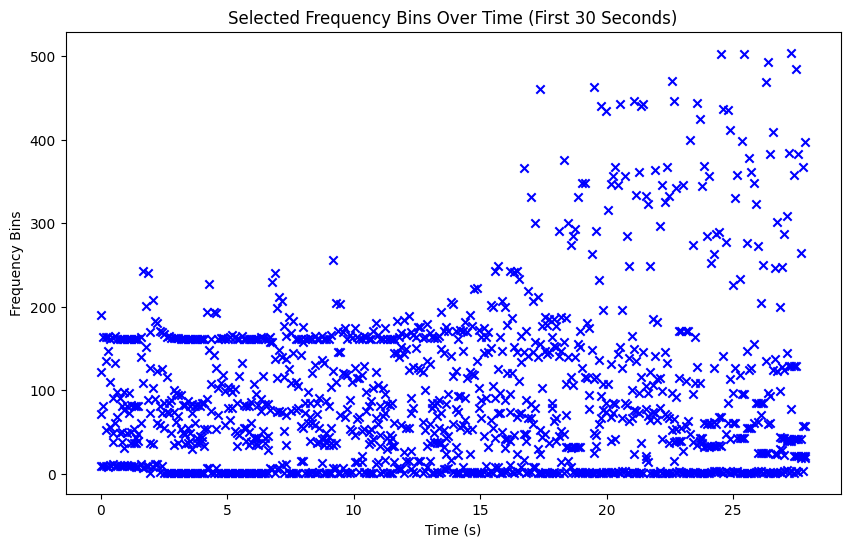

In [3]:
fft_results, sr = get_spectogram("data/fma_small/135/135054.mp3")

const_map = create_constellation_map(
    fft_results, frame_duration=0.1, sr=22050, hop_length=551, mean_coefficient=0.8
)

plot_constellation_map(const_map, with_indexes=False, duration=30)

## Step 3: Extract the Addresses and the Couples From the Constellation Map

This step is also not a common operation. Again, Shazam's official paper is not giving detailed information how they are extracting the addresses and couples from the constellation map. However, they gave the general idea behing the method. We are filling the gaps with our experience and the information from the blog writing "How Shazam Works?".


- For each peak(anchor frequencies), select a target zone with a size.
- For each target zone, compare every elemnt in the target zone with the anchor frequency.
- Get the time difference, two frequencies, and the absolute time of the anchor frequency.
- Create the addresses using [f1, f2, dt] and the couples using [anchor_time, song_id].


These little addresses are the fingerprints of the song. We are going to use these fingerprints to find the requested songs.

In [4]:
address_couples = create_address_couples_from_audios(
    {"000002": "data/fma_small/000/000002.mp3"}
)
print("Address couples shape:")
print(address_couples.shape, "\n")
print("First 5 address couples:")
print(address_couples[:5])

Address couples shape:
(6750, 5) 

First 5 address couples:
[[1.40000000e+01 7.00000000e+00 9.28798186e-02 0.00000000e+00
  2.00000000e+00]
 [1.40000000e+01 2.70000000e+01 9.28798186e-02 0.00000000e+00
  2.00000000e+00]
 [1.40000000e+01 5.10000000e+01 9.28798186e-02 0.00000000e+00
  2.00000000e+00]
 [1.40000000e+01 1.57000000e+02 9.28798186e-02 0.00000000e+00
  2.00000000e+00]
 [1.40000000e+01 4.99000000e+02 9.28798186e-02 0.00000000e+00
  2.00000000e+00]]


## Algorithm

### Step 1: Read the audio, extract the spectrogram

We are using the librosa library to read the audio and extract the spectrogram. We are using the default parameters of the librosa library.

### Step 2: Extract the constellation map from the spectrogram

We are using the peak detection algorithm to extract the constellation map from the spectrogram. We are using the peak detection algorithm from the scipy library. We are using the default parameters of the peak detection algorithm.

### Step 3: Extract the Addresses and the Couples From the Constellation Map

We are using the addresses and couples extraction algorithm to extract the addresses and couples from the constellation map. We are using the default parameters of the addresses and couples extraction algorithm.

### Step 4: Get the recording from user and apply the steps 1, 2, and 3 to the recording

We are using the same steps to extract the addresses and couples from the recording(query).

### Step 5: Compare the recording's fingerprint with the fingerprints of the songs in the database

We are comparing the addresses of the queries, and the addresses of the songs in the database. In this part, there is a match called **Target Zone Match**. This is the most important match for song comparison. Then, the address matching comes.

### Step 6: Return the song with the target zone match, and the address match respectively

In [5]:
audios = load_audios("data/fma_small", num_audios=10)
print("Loaded audios:")
pprint(audios)

Loaded audios:
{'135043': 'data/fma_small/135/135043.mp3',
 '135044': 'data/fma_small/135/135044.mp3',
 '135054': 'data/fma_small/135/135054.mp3',
 '135091': 'data/fma_small/135/135091.mp3',
 '135092': 'data/fma_small/135/135092.mp3',
 '135221': 'data/fma_small/135/135221.mp3',
 '135336': 'data/fma_small/135/135336.mp3',
 '135337': 'data/fma_small/135/135337.mp3',
 '135369': 'data/fma_small/135/135369.mp3',
 '135989': 'data/fma_small/135/135989.mp3'}


In [20]:
### Save spectograms and constellation maps to avoid recomputing them ###

audios = load_audios("data/fma_small", num_audios=10)

if not os.path.exists("cache/spectograms/2205_10.npy"):
    print("Creating spectograms cache...")
    save_spectograms("data/fma_small", "cache/spectograms/2205_10.npy", num_audios=10)
    
if not os.path.exists("cache/constellation_maps/10_0.8.npy"):
    print("Creating constellation maps cache...")
    save_constellation_maps("cache/spectograms", "cache/constellation_maps/10_0.8.npy")


In [16]:
db = create_address_couples("cache/constellation_maps/10_0.8.npy")

audios = load_audios("data/fma_small", num_audios=10)

average_time = 0

for song_id, audio_path in audios.items():
    t1 = time.time()
    search_song(db, audio_path, target_audio_record_seconds=10)
    average_time += time.time() - t1


print("Average time of a search: ", average_time / len(audios))

The target song is found correct!
Song ID: 135054, Target Zone Matches: 368,                Address Matches: 2299
Song ID: 135369, Target Zone Matches: 222,                Address Matches: 1372
Song ID: 135091, Target Zone Matches: 128,                Address Matches: 945
The target song is found correct!
Song ID: 135336, Target Zone Matches: 479,                Address Matches: 2872
Song ID: 135092, Target Zone Matches: 172,                Address Matches: 1109
Song ID: 135337, Target Zone Matches: 93,                Address Matches: 740
The target song is found correct!
Song ID: 135337, Target Zone Matches: 561,                Address Matches: 3293
Song ID: 135044, Target Zone Matches: 137,                Address Matches: 955
Song ID: 135336, Target Zone Matches: 114,                Address Matches: 816
The target song is found correct!
Song ID: 135043, Target Zone Matches: 108,                Address Matches: 850
Song ID: 135221, Target Zone Matches: 39,                Address Match

### Average Time to Search a Song in the 10 Song Dataset: 5 Seconds

## Defining the Fully Encrypted Circuit

The fully encrypted circuit is defined in the following cell. The circuit's dimension are the same with the chunk size of the dataset.


In [6]:
NUM_ENTRIES = 25
NUM_QUERIES = 4
NUM_COLUMNS = 7

configuration = fhe.Configuration(
    comparison_strategy_preference=fhe.ComparisonStrategy.ONE_TLU_PROMOTED,
    p_error=1e-6,
)


@fhe.compiler({"db": "encrypted", "query": "encrypted"})
def search(db: fhe.uint3, query: fhe.uint3):
    fhe.hint(db, bit_width=4)
    fhe.hint(query, bit_width=4)

    query_expanded = fhe.hint(np.expand_dims(query, axis=1), bit_width=3)

    matches_1 = fhe.hint(np.sum(db == query_expanded, axis=2), bit_width=2)

    matches_2 = fhe.hint(np.sum(matches_1 == NUM_COLUMNS, axis=0), bit_width=1)

    address_matches = fhe.hint(np.sum(matches_2), bit_width=int(np.log2(NUM_ENTRIES)))

    return address_matches

In [7]:
db = create_address_couples_by_song("cache/constellation_maps/10_0.8.npy")

audios = load_audios("data/fma_small", num_audios=10)


query_path = list(audios.items())[0][1]
query = create_query_integer(query_path, target_audio_record_seconds=3)

db = chunk_anchor_times_of_songs(db, NUM_ENTRIES)
db = chunkify_bits_of_db(db)
query = chunkify_bits_of_array(query)


inputset = [
    (
        db[0][i][:, :NUM_COLUMNS],
        query[NUM_QUERIES * i : NUM_QUERIES * (i + 1)],
    )
    for i in range(10)
]

match_indices = search.compile(inputset, configuration=configuration)

IndexError: index 23 is out of bounds for axis 1 with size 5

In [ ]:
print(match_indices)

%0 = db                             # EncryptedTensor<uint4, shape=(25, 7)>           ∈ [0, 7]
%1 = query                          # EncryptedTensor<uint4, shape=(4, 7)>            ∈ [0, 7]
%2 = expand_dims(%1, axis=1)        # EncryptedTensor<uint3, shape=(4, 1, 7)>         ∈ [0, 7]
%3 = equal(%0, %2)                  # EncryptedTensor<uint1, shape=(4, 25, 7)>        ∈ [0, 1]
%4 = sum(%3, axis=2)                # EncryptedTensor<uint2, shape=(4, 25)>           ∈ [0, 5]
%5 = 7                              # ClearScalar<uint3>                              ∈ [7, 7]
%6 = equal(%4, %5)                  # EncryptedTensor<uint1, shape=(4, 25)>           ∈ [0, 0]
%7 = sum(%6, axis=0)                # EncryptedTensor<uint1, shape=(25,)>             ∈ [0, 0]
%8 = sum(%7)                        # EncryptedScalar<uint4>                          ∈ [0, 0]
return %8


## Circuit Simulation

The circuit is simulated in the following cell. The simulation time is printed out. Circuit is searching for a selected song from the database. 

In [ ]:
query_index = 0
simulated_results = {}

while query_index < len(query):
    query_chunk = query[query_index : query_index + NUM_QUERIES]
    print(f"Query Chunk: {query_index} - {query_index + NUM_QUERIES}")
    for song in db:
        song_id = song[0][0][5]
        if song_id not in simulated_results:
            simulated_results[song_id] = []

        db_results = []

        for i, chunk in enumerate(song):
            results = match_indices.simulate(chunk[:, :NUM_COLUMNS], query_chunk)

            db_results.append(results)

        simulated_results[song_id].append(np.array(db_results))

    query_index += NUM_QUERIES


matches = 0
for i, (song, enc_results) in enumerate(simulated_results.items()):
    results = np.array(enc_results).reshape(-1, len(db[i]))
    results = np.sum(results, axis=0)

    simulated_results[song] = results

    matches.append((song, np.sum(np.array(results) // 5), np.sum(results)))

simulation_matches = sorted(matches, key=lambda x: (x[1], x[2]), reverse=True)

## Circuit Performance Analysis

We ran the circuit for a 10 song database searching 1 song, but simulated it. The simulation time is given above. We will have a look at the performance of the circuit for different by encrypting the data.

In [11]:
t1 = time.time()
encrypted_address = match_indices.encrypt(
    db[0][0][:, :NUM_COLUMNS],
    query[:NUM_QUERIES],
)
print(f"Encryption time: {time.time() - t1}")

t1 = time.time()
results = match_indices.run(encrypted_address)
print(f"Computation time: {time.time() - t1}")

t1 = time.time()
decrypted_results = match_indices.decrypt(results)
print(f"Decryption time: {time.time() - t1}")

Encryption time: 3.3219850063323975
Computation time: 6.063081979751587
Decryption time: 0.00020003318786621094
0


Circuit's performance is divided into three stages, encryption, computation and decryption. 
**For the chunk size 25x4,** 

- Encryption: **3.2** seconds
- Computation: **6**
- Decryption: **2e-4** seconds


In [9]:
total_chunks_in_db = 0

for song in db:
    total_chunks_in_db += song.shape[0]

print(f"Total chunks in db: {total_chunks_in_db}")
print(f"Total chunks in query: {query.shape[0] // NUM_QUERIES}")

print(
    f"Total number needed to be computed: {total_chunks_in_db * query.shape[0] // NUM_QUERIES}"
)
print(f"Each chunk takes total of 6 seconds to compute")
print(
    f"Total time needed to compute: {6 * total_chunks_in_db * query.shape[0] // NUM_QUERIES / 60 / 60:.2f} hours"
)

Total chunks in db: 2984
Total chunks in query: 142
Total number needed to be computed: 425220
Each chunk takes total of 9.2 seconds to compute
Total time needed to compute: 1086.67 hours


## Performance Discussion

As can be seen, circuit has almost no room for optimization. Instead of trying to compress the circuit, we can try to compress the data. The motivation behind this project is to provide privacy. Since we are currently encrypting the whole data, computation takes too much time. After all, there is a minimum number of comparisons that we need to do. We can not reduce the number of comparisons. However, we can extract some of the comparison to the outside of the circuit. We observed that encrypting only 1 value of the addresses does not affect the privacy. In the server side, it cannot be seen the preference of the requested song. Furthemore, instead of encrypting the two values in the addresses, we propose a bitwise configuration to select the number of bits to encrypt. 

### Total Bits, Encrypted Bits, and the Number of Comparisons

We have 3 values to compare, these are:

- f1 0 - 511(9 bit unsigned integer)
- f2 0 - 511 (9 bit unsigned integer)
- dt (3 bit unsigned integer)

Total of 21 bits. We are providing user to select the number of bits to encrypt. For example, if the user selects 10 bits to encrypt, then the circuit will encrypt 10 bits of the total 21 bits. The remaining 11 bits will be compared before the circuit. Both the comparison number and the size of the circuit will reduce significantly.

In [49]:
NUMBER_OF_BITS_TO_ENCRYPT = 15

In [51]:
def run_with_configurable_bits(db, query):
    assert NUMBER_OF_BITS_TO_ENCRYPT != 0
    assert NUMBER_OF_BITS_TO_ENCRYPT <= 21

    db = merge_numbers_bitwise(db, NUMBER_OF_BITS_TO_ENCRYPT)
    query = merge_numbers_bitwise(query, NUMBER_OF_BITS_TO_ENCRYPT)

    if NUMBER_OF_BITS_TO_ENCRYPT % 4 == 0:
        ENCRYPT_COLUMNS = NUMBER_OF_BITS_TO_ENCRYPT // 4
    else:
        ENCRYPT_COLUMNS = NUMBER_OF_BITS_TO_ENCRYPT // 4 + 1


    db = db[np.where(np.sum((db[:, 0] == query[:, 0].reshape(-1, 1)), axis=0))[0]]

    db = db[:, 1:]
    query = query[:, 1:]
    ## End of outside comparison

    db = split_db_into_songs(db, ENCRYPT_COLUMNS + 1)

    NUM_ENTRIES = 25
    NUM_QUERIES = 4

    configuration = fhe.Configuration(
        comparison_strategy_preference=fhe.ComparisonStrategy.ONE_TLU_PROMOTED,
        p_error=1e-6,
    )

    db = chunk_anchor_times_of_songs(db, ENCRYPT_COLUMNS + 2, NUM_ENTRIES)


    @fhe.compiler({"db": "encrypted", "query": "encrypted"})
    def search(db: fhe.uint3, query: fhe.uint3):
        fhe.hint(db, bit_width=4)
        fhe.hint(query, bit_width=4)

        query_expanded = fhe.hint(np.expand_dims(query, axis=1), bit_width=3)

        matches_1 = fhe.hint(np.sum(db == query_expanded, axis=2), bit_width=2)

        matches_2 = fhe.hint(np.sum(matches_1 == ENCRYPT_COLUMNS, axis=0), bit_width=1)

        address_matches = fhe.hint(np.sum(matches_2), bit_width=int(np.log2(NUM_ENTRIES)))

        return address_matches


    inputset = [
        (
            db[0][i][:, :ENCRYPT_COLUMNS],
            np.concatenate((query[NUM_QUERIES * i: NUM_QUERIES * (i + 1) - 1], db[0][i][:1,:ENCRYPT_COLUMNS]))
        )
        for i in range(10)
    ]

    search_circuit = search.compile(inputset, configuration=configuration)
    
    
    t1 = time.time()
    encrypted_address = search_circuit.encrypt(
        db[0][0][:, :ENCRYPT_COLUMNS],
        query[:NUM_QUERIES],
    )
    print(f"Encryption time: {time.time() - t1}")

    t1 = time.time()
    results = search_circuit.run(encrypted_address)
    computation_time = time.time() - t1
    print(f"Computation time: {computation_time}")

    t1 = time.time()
    decrypted_results = search_circuit.decrypt(results)
    print(f"Decryption time: {time.time() - t1}")
    
    return computation_time

db = create_address_couples("cache/constellation_maps/10_0.8.npy")

db[:, 2] = db[:, 2] * 10
db[:, 3] = db[:, 3] * 100

db = db.astype(np.uint32)

query_path = "data/fma_small/135/135054.mp3"
query = create_query_integer(query_path, target_audio_record_seconds=3)


run_with_configurable_bits(db, query)

--------------------------------------------------
Encryption time: 5.349181890487671
Computation time: 5.7622010707855225
Decryption time: 7.104873657226562e-05


5.7622010707855225

In [52]:
db = create_address_couples("cache/constellation_maps/10_0.8.npy")

db[:, 2] = db[:, 2] * 10
db[:, 3] = db[:, 3] * 100

db = db.astype(np.uint32)

query_path = "data/fma_small/135/135054.mp3"
query = create_query_integer(query_path, target_audio_record_seconds=3)

computation_times = []

for i in range(1, 22):
    NUMBER_OF_BITS_TO_ENCRYPT = i
    print("-" * 50)
    print(f"Number of bits to encrypt: {i}")
    computation_times.append(run_with_configurable_bits(db, query))
    
db = split_db_into_songs(db, 4)
db = chunk_anchor_times_of_songs(db, 5, NUM_ENTRIES)

total_chunks_in_db = 0

for song in db:
    total_chunks_in_db += song.shape[0]
    
    
total_times = []
for i in computation_times:
    total_time = i * total_chunks_in_db * query.shape[0] // NUM_QUERIES / 60 / 60
    total_times.append(total_time)

Number of bits to encrypt: 1
--------------------------------------------------
Encryption time: 2.722719192504883
Computation time: 1.1568410396575928
Decryption time: 5.602836608886719e-05
Number of bits to encrypt: 2
--------------------------------------------------
Encryption time: 3.143977403640747
Computation time: 1.0552351474761963
Decryption time: 5.984306335449219e-05
Number of bits to encrypt: 3
--------------------------------------------------
Encryption time: 3.090920925140381
Computation time: 1.5006849765777588
Decryption time: 6.67572021484375e-05
Number of bits to encrypt: 4
--------------------------------------------------
Encryption time: 4.566076993942261
Computation time: 1.4433481693267822
Decryption time: 7.295608520507812e-05
Number of bits to encrypt: 5
--------------------------------------------------
Encryption time: 4.588788032531738
Computation time: 2.8452181816101074
Decryption time: 6.29425048828125e-05
Number of bits to encrypt: 6
------------------

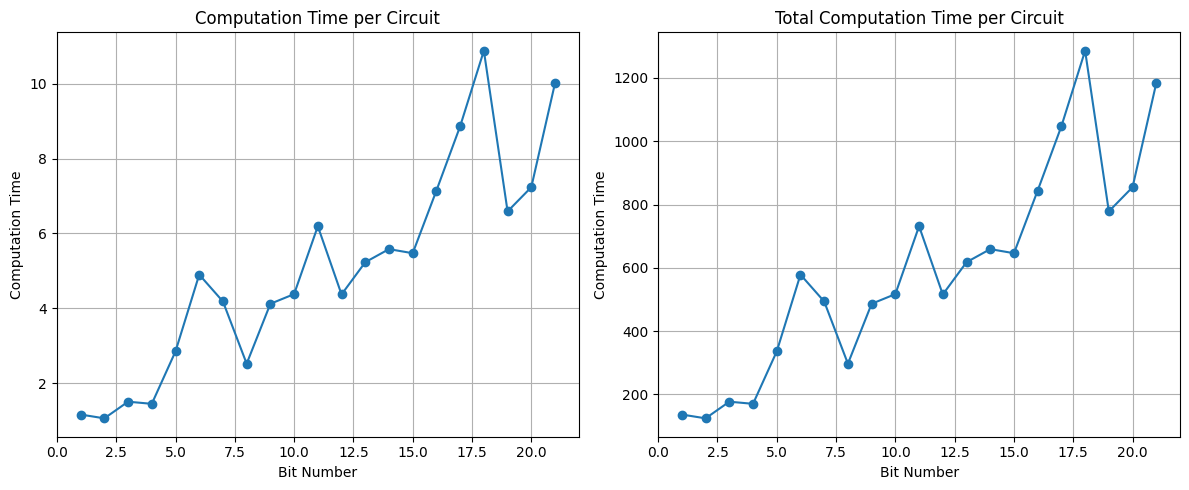

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

bit_numbers = list(range(1, len(computation_times) + 1))

# Plot the first graph (computation_times)
axs[0].plot(bit_numbers, computation_times, marker='o', linestyle='-')
axs[0].set_title('Computation Time per Circuit')
axs[0].set_xlabel('Bit Number')
axs[0].set_ylabel('Computation Time')
axs[0].grid(True)

# Plot the second graph (total_times)
axs[1].plot(bit_numbers, total_times, marker='o', linestyle='-')
axs[1].set_title('Total Computation Time per Circuit')
axs[1].set_xlabel('Bit Number')
axs[1].set_ylabel('Computation Time')
axs[1].grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

